Per evitare di dover rieseguire tutto il Colab ogni volta, la SVM addestrata è salvata su Drive. Per far funzionare il codice non serve quindi eseguire le celle "Oversampling", "SVM training" e "Salvataggio SVM".

# Importazione e modifica dati

In [ ]:
from google.colab import drive 
import pandas as pd
import re
import numpy as np
from math import exp

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import joblib

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7] # dimensione grafici

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/dataset_normalizzato.csv')

In [ ]:
df.head()

,ad_form_id,clicks,impressions,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,...,categories2_welfare,categories2_windsurfing,categories2_womenshealth,categories2_work,categories2_wrestling,categories2_zoo,feelings1_amusement,feelings1_emotions,feelings1_pain,feelings1_others
0,8408205703932483258,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,6157419832685345406,0,3,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,6336227050936118437,0,3,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,56.25,43.75,0.0,0.0
3,6272249560265519045,0,5,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
4,2248420359615433360,0,5,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0


Aggiungiamo colonna click_status:

In [ ]:
def clickstatus(riga):
  if riga['clicks']>0:
    return 'yes'
  else:
    return 'no'

df['click_status'] = df.apply(clickstatus, axis=1)
df.drop(columns='clicks', inplace=True)

In [ ]:
# totale dei click
len(df[df['click_status']=='yes'])

189

In [ ]:
# totale dei non click
len(df[df['click_status']=='no'])

62190

Eliminazione colonna Id e Impression:

In [ ]:
df.drop(columns='ad_form_id', inplace=True)

In [ ]:
df.drop(columns='impressions', inplace=True)

Tipi delle variabili:

In [ ]:
df.dtypes

os_android               int64
os_bsd                   int64
os_ios                   int64
os_linux                 int64
os_osx                   int64
                        ...   
feelings1_amusement    float64
feelings1_emotions     float64
feelings1_pain         float64
feelings1_others       float64
click_status            object
Length: 425, dtype: object

In [ ]:
df = df.astype({
    'os_android':'bool',
    'os_bsd':'bool',
    'os_ios':'bool',
    'os_linux':'bool',
    'os_osx':'bool',
    'os_other':'bool',
    'os_windows':'bool',
    'device_type':'object',
    'browser_android':'bool',
    'browser_chrome':'bool',
    'browser_chromium':'bool',
    'browser_edge':'bool',
    'browser_firefox':'bool',
    'browser_ie':'bool',
    'browser_opera':'bool',
    'browser_other':'bool',
    'browser_safari':'bool',
    'browser_unknown':'bool'
}) 

# Caricamento SVM

In [ ]:
try:
  pipeline = joblib.load('/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat1.sav')
except:
  print('Il file SVM_cat1.sav non è stato trovato.')

# Dataset per il training

Tengo solo categories1 e feelings, elimino le categories2

In [ ]:
colonne = list(df.columns)

# Colonne categories2
cat2 = re.compile('categories2_+.*', re.IGNORECASE)
cats2 = []
for label in colonne:
  occ = cat2.findall(label)
  if occ:
    cats2.append(occ[0])

df.drop(columns=cats2, inplace=True)

In [ ]:
df

,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,device_type,browser_android,browser_chrome,...,categories1_sports,categories1_styleandfashion,categories1_technologyandcomputing,categories1_travel,categories1_uncategorized,feelings1_amusement,feelings1_emotions,feelings1_pain,feelings1_others,click_status
0,False,False,False,False,False,False,True,2,False,False,...,0.00,0.0,0.00,0.0,57.89,0.00,0.00,0.0,0.0,no
1,False,False,False,False,False,False,True,2,False,True,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,no
2,False,False,False,False,False,False,True,2,False,True,...,11.76,0.0,11.76,0.0,0.00,56.25,43.75,0.0,0.0,no
3,False,False,False,False,False,False,True,2,False,True,...,14.71,0.0,51.49,0.0,0.00,0.00,0.00,0.0,0.0,no
4,False,False,False,False,False,False,True,2,False,False,...,0.00,0.0,57.39,0.0,42.61,0.00,0.00,0.0,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62374,False,False,False,False,True,False,False,2,False,True,...,0.00,0.0,40.00,0.0,0.00,56.10,43.90,0.0,0.0,no
62375,False,False,False,False,False,False,True,2,False,True,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,no
62376,False,False,False,False,False,False,True,2,False,True,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,no
62377,False,False,False,False,False,False,True,2,False,True,...,3.77,0.0,42.96,0.0,0.00,56.17,43.96,0.0,0.0,no


Il dataset ha ora 66 colonne.

# Split train test

In [ ]:
feature_names = df.columns.drop('click_status')

(train_x, test_x,
 train_y, test_y) = train_test_split(df[feature_names], 
                                     df['click_status'],
                                     test_size=0.3, 
                                     random_state=42)

# Oversampling

In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
train_x_ros, train_y_ros= ros.fit_resample(train_x, train_y)
# Check the number of records after over sampling
print(sorted(Counter(train_y_ros).items()))

[('no', 43529), ('yes', 43529)]


In [ ]:
# controllo tipo colonne
df.dtypes

os_android                bool
os_bsd                    bool
os_ios                    bool
os_linux                  bool
os_osx                    bool
                        ...   
feelings1_amusement    float64
feelings1_emotions     float64
feelings1_pain         float64
feelings1_others       float64
click_status            object
Length: 66, dtype: object

In [ ]:
# Controllo train set oversamplato
train_x_ros

# SVM training

In [ ]:
# Seleziono variabili categoriche e numeriche
cat_ix = train_x_ros.select_dtypes(include=['object', 'bool']).columns
num_ix = train_x_ros.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# Encoding e normalizzazione(tra 0 e 1)
ct = ColumnTransformer([('c', OneHotEncoder(handle_unknown = 'ignore'), cat_ix),
                        ('n', MinMaxScaler(), num_ix)])

In [ ]:
# SVM
model = svm.LinearSVC()

In [ ]:
# Definisco pipeline 
pipeline = Pipeline(steps=[('t', ct), ('m', model)])

In [ ]:
# Addestramento
pipeline.fit(train_x_ros, train_y_ros)

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['os_android', 'os_bsd', 'os_ios', 'os_linux', 'os_osx', 'os_other',
       'os_windows', 'device_type', 'browser_android', 'browser_chrome',
       'browser_chromium', 'browser_edge', 'browser_firefox', 'browser_ie',
       'browser_opera', 'browser_other', 'browser_safari', 'browser...
       'categories1_religionandspirituality', 'categories1_science',
       'categories1_shopping', 'categories1_society', 'categories1_sports',
       'categories1_styleandfashion', 'categories1_technologyandcomputing',
       'categories1_travel', 'categories1_uncategorized',
       'feelings1_amusement', 'feelings1_emotions', 'feelings1_pain',
       'feelings1_others'],
      dtype='object'))])),
                ('m', LinearSVC())])

In [ ]:
# Performance sul train test
y_pred_train = pipeline.predict(train_x_ros)
print(classification_report(train_y_ros, y_pred_train)) # precision, recall e altre misure di performance

              precision    recall  f1-score   support

          no       0.67      0.61      0.64     43529
         yes       0.64      0.70      0.67     43529

    accuracy                           0.66     87058
   macro avg       0.66      0.66      0.66     87058
weighted avg       0.66      0.66      0.66     87058



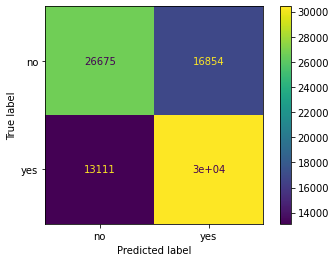

In [ ]:
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, train_x_ros, train_y_ros);

In [ ]:
# Percentuali:
a = 26675
b = 16854
c = 13111
d = 3e4
no = a + b
yes = c + d
CM11 = round(a / no, 2)
CM12 = round(b / no, 2)
CM21 = round(c / yes, 2)
CM22 = round(d / yes, 2)
print(f'% no classificati come no: {CM11}\n% no classicati come sì: {CM12}\n% sì classificati come no: {CM21}\n% sì classificati come sì: {CM22}')

% no classificati come no: 0.61
% no classicati come sì: 0.39
% sì classificati come no: 0.3
% sì classificati come sì: 0.7


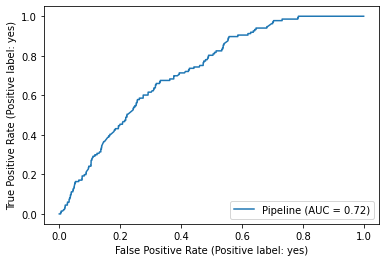

In [ ]:
# Curva ROC
RocCurveDisplay.from_estimator(pipeline, train_x_ros, train_y_ros);

# Salvataggio della SVM

In [ ]:
# Eseguire solo se si riaddestra la SVM
#joblib.dump(pipeline, '/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat1.sav')

['/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat1.sav']

In [ ]:
# Versione di sklearn
import sklearn
sklearn.__version__

'1.0.2'

SVM salvata con versione 1.0.2 di `sklearn`.

# Test

In [ ]:
# Predizione su test set
y_pred = pipeline.predict(test_x)
print(classification_report(test_y, y_pred)) # precision, recall e altre misure di performance

              precision    recall  f1-score   support

          no       1.00      0.61      0.76     18661
         yes       0.00      0.64      0.01        53

    accuracy                           0.61     18714
   macro avg       0.50      0.62      0.38     18714
weighted avg       1.00      0.61      0.75     18714



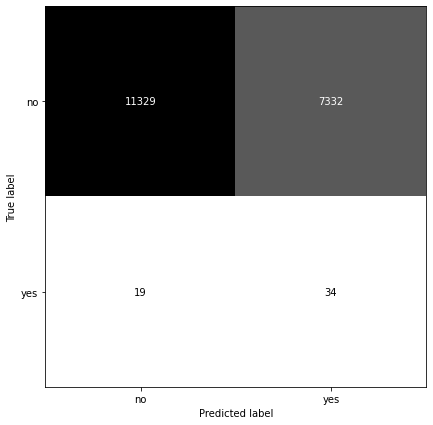

In [ ]:
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False, cmap='gist_yarg');

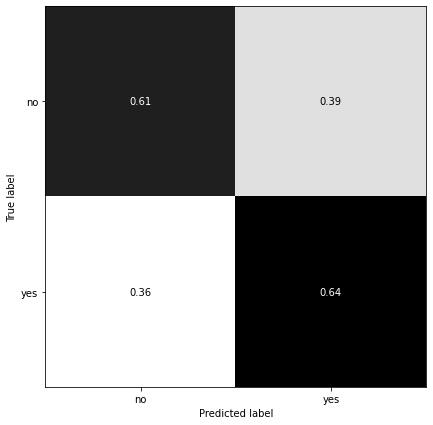

In [ ]:
# Matrice di confusione con percentuali
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False, cmap='binary', normalize='true');

In [ ]:
# Percentuali:
a = 11329
b = 7332
c = 19
d = 34
no = a + b
yes = c + d
CM11 = round(a / no, 2)
CM12 = round(b / no, 2)
CM21 = round(c / yes, 2)
CM22 = round(d / yes, 2)
print(f'% no classificati come no: {CM11}\n% no classicati come sì: {CM12}\n% sì classificati come no: {CM21}\n% sì classificati come sì: {CM22}')

% no classificati come no: 0.61
% no classicati come sì: 0.39
% sì classificati come no: 0.36
% sì classificati come sì: 0.64


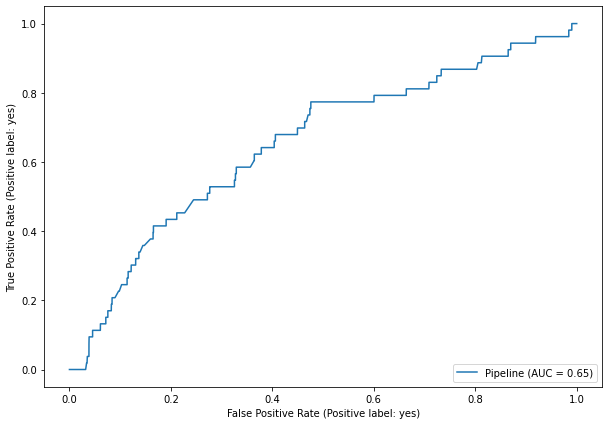

In [ ]:
# Curva ROC
RocCurveDisplay.from_estimator(pipeline, test_x, test_y);

# Costruzione del dataframe per la valutazione

Innanzitutto portiamo la confidenza tra 0 e 1.

Da guida di `sklearn` su decision function di `linearSVC`:

*Predict confidence scores for samples.*

*The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.*

*Parameters*
  * *X{array-like, sparse matrix} of shape (`n_samples`, `n_features`)*
    * *The data matrix for which we want to get the confidence scores.*

*Returns*
  * *scores: ndarray of shape (`n_samples`,) or (`n_samples`, `n_classes`)*
    * *Confidence scores per (`n_samples`, `n_classes`) combination. In the binary case, confidence score for `self.classes_[1]` where >0 means this class would be predicted.*

In [ ]:
# Confidenza dei sì
probs = list(pipeline.decision_function(test_x))

In [ ]:
probs[:10]

[-1.001913458063206,
 0.08313321039296126,
 -2.659611458456901,
 -0.25100150915219344,
 -0.12279400850699343,
 -0.8358491295140338,
 0.3453885873952973,
 -0.2989960540621476,
 0.6543467381175248,
 -0.6730703831396444]

In [ ]:
# Le entrate negative sono associate al no, le positive al sì, come mostrato qui sotto
y_pred[:10]

array(['no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no'],
      dtype=object)

In [ ]:
# Costruisco ora dataframe con id, la classe vera, la classe predetta e la probabilità associata al sì
yes_df = pd.DataFrame()

In [ ]:
yes_df['id'] = range(len(probs))
yes_df['Class'] = list(test_y)
yes_df['Predicted'] = list(y_pred)
yes_df['Confidence of yes'] = probs

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes
0,0,no,no,-1.001913
1,1,no,yes,0.083133
2,2,no,no,-2.659611
3,3,no,no,-0.251002
4,4,no,no,-0.122794
...,...,...,...,...
18709,18709,no,no,-0.238667
18710,18710,no,yes,0.098848
18711,18711,no,no,-0.119213
18712,18712,no,yes,0.287870


Si può mappare la confidenza tra 0 e 1 usando:

$\frac{1}{1+e^{-c}},$

con c livello di confidenza

**ATTENZIONE**: i valori non seguono nessuna distribuzione di probabilità.

In [ ]:
def ctp(riga):
  return 1 / (1 + exp(-riga['Confidence of yes']))
yes_df['Confidence of yes'] = yes_df.apply(ctp, axis=1)

In [ ]:
yes_df[yes_df['Class'] == 'yes'].sort_values('Confidence of yes', ascending=False)

,id,Class,Predicted,Confidence of yes
14815,14815,yes,yes,0.633832
1388,1388,yes,yes,0.631433
8038,8038,yes,yes,0.626714
13515,13515,yes,yes,0.626714
13508,13508,yes,yes,0.626604
17123,17123,yes,yes,0.617748
6755,6755,yes,yes,0.605972
14260,14260,yes,yes,0.598701
1202,1202,yes,yes,0.596006
8776,8776,yes,yes,0.591290


In [ ]:
yes_df.groupby('Class').size()

Class
no     18661
yes       53
dtype: int64

In [ ]:
Nno = 18661
Nyes = 53

# Valutazione performance con curva ROC
Riguardare con attenzione!

## Determinazione della soglia

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes
0,0,no,no,0.268565
1,1,no,yes,0.520771
2,2,no,no,0.065399
3,3,no,no,0.437577
4,4,no,no,0.469340
...,...,...,...,...
18709,18709,no,no,0.440615
18710,18710,no,yes,0.524692
18711,18711,no,no,0.470232
18712,18712,no,yes,0.571475


In [ ]:
soglie = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # soglie a cui guardiamo true positive rate e false positive rate
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna predict soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.1,0.962264,0.980494
1,0.2,0.962264,0.963400
2,0.3,0.962264,0.923262
3,0.4,0.867925,0.735813
4,0.5,0.641509,0.392905
5,0.6,0.132075,0.069182
6,0.7,0.000000,0.006752
7,0.8,0.000000,0.000375
8,0.9,0.000000,0.000000
9,1.0,0.000000,0.000000


**I RISULTATI A SOGLIA 0.5 COINCIDONO CON QUELLI DELLA MATRICE DI CONFUSIONE, MEGA YEEE!!!!!**

Visti i risultati, analizziamo meglio tra 0.4 e 0.5.

In [ ]:
soglie = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna predict soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.40,0.867925,0.735813
1,0.41,0.830189,0.709233
2,0.42,0.811321,0.674616
3,0.43,0.792453,0.644606
4,0.44,0.773585,0.590001
5,0.45,0.773585,0.545416
6,0.46,0.773585,0.505546
7,0.47,0.735849,0.470929
8,0.48,0.679245,0.443545
9,0.49,0.679245,0.420128


Visti i risultati, analizziamo meglio tra 0.45 e 0.48.

In [ ]:
soglie = np.arange(0.45, 0.481, 0.001)
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna predict soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.450,0.773585,0.545416
1,0.451,0.773585,0.543969
2,0.452,0.773585,0.540486
3,0.453,0.773585,0.538074
4,0.454,0.773585,0.529125
5,0.455,0.773585,0.526660
6,0.456,0.773585,0.519586
7,0.457,0.773585,0.513584
8,0.458,0.773585,0.511334
9,0.459,0.773585,0.508011


La scelta più sensata sembra essere 0.468, quindi:

In [ ]:
soglia = 0.468

## Dataframe con classe predetta sulla base della soglia scelta con curva ROC

In [ ]:
# Funzione che calcola la prediction sulla base della soglia scelta con curva ROC
def prediction_soglia(riga):
  if riga['Confidence of yes'] > soglia:
    return 'yes'
  else:
    return 'no'

In [ ]:
yes_df['Prediction soglia'] = yes_df.apply(prediction_soglia, axis=1)

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes,Prediction soglia
0,0,no,no,0.268565,no
1,1,no,yes,0.520771,yes
2,2,no,no,0.065399,no
3,3,no,no,0.437577,no
4,4,no,no,0.469340,yes
...,...,...,...,...,...
18709,18709,no,no,0.440615,no
18710,18710,no,yes,0.524692,yes
18711,18711,no,no,0.470232,yes
18712,18712,no,yes,0.571475,yes


## Valutazione metriche e matrice di confusione con la nuova soglia

In [ ]:
# Salvo in una lista le predizioni sulla base della soglia scelta con curva ROC
# In questo modo costruisco una lista analoga a test_y, ma con yes e no scelti non sulla base della soglia 0.5
# ma sulla base della soglia scelta con curva ROC
y_pred2 = yes_df['Prediction soglia'].tolist()

print(classification_report(test_y, y_pred2))

              precision    recall  f1-score   support

          no       1.00      0.52      0.69     18661
         yes       0.00      0.77      0.01        53

    accuracy                           0.52     18714
   macro avg       0.50      0.65      0.35     18714
weighted avg       1.00      0.52      0.69     18714



In [ ]:
# Verifica
tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')]) # veri positivi
tn = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'no')]) # veri negativi

accuracy = (tp + tn) / len(yes_df)

round(accuracy, 2)

0.52

La vecchia accuracy era pari a 0.61.

---
Confronto la matrice di confusione.

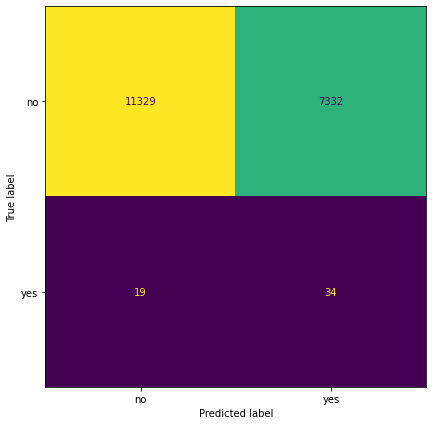

In [ ]:
# Vecchia matrice di confusione
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False);

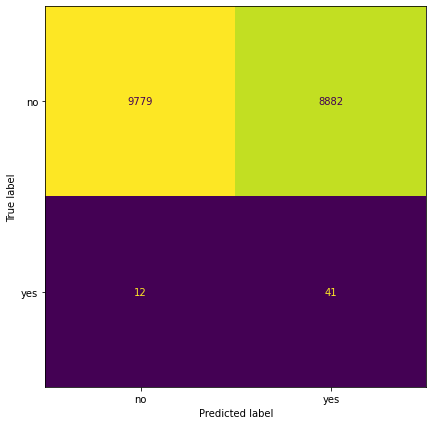

In [ ]:
# Nuova matrice di confusione
ConfusionMatrixDisplay.from_predictions(test_y, y_pred2, colorbar=False);

# Valutazione performance con quantili

## Mediana

In [ ]:
# Individuo la mediana e divido in gruppi
group1 = yes_df[yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].median()]
group2 = yes_df[yes_df['Confidence of yes'] < yes_df['Confidence of yes'].median()]

In [ ]:
yes_df['Confidence of yes'].median()

0.4618178567490153

In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(group1[group1['Class'] == 'yes'].count())[2]}/{len(group1)}={round(list(group1[group1['Class'] == 'yes'].count() / len(group1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(group1[group1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(group1[group1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 41/9357=0.004
Frazione di sì reali nel primo gruppo su tutti i sì: 41/53
Frazione di no reali nel primo gruppo su tutti i no: 9316/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(group2[group2['Class'] == 'yes'].count())[2]}/{len(group2)}={round(list(group2[group2['Class'] == 'yes'].count() / len(group2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(group2[group2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(group2[group2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 12/9357=0.001
Frazione di sì reali nel secondo gruppo su tutti i sì: 12/53
Frazione di no reali nel secondo gruppo su tutti i no: 9345/18661


## Quartili

In [ ]:
quart1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
quart2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
quart3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
quart4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

In [ ]:
# Quartili
print(f"q_0.75 = {yes_df['Confidence of yes'].quantile(q=0.75)}")
print(f"mediana = {yes_df['Confidence of yes'].quantile(q=0.5)}")
print(f"q_0.25 = {yes_df['Confidence of yes'].quantile(q=0.25)}")
print(f"q_0 = {yes_df['Confidence of yes'].quantile(q=0)}")

q_0.75 = 0.5484427124380522
mediana = 0.4618178567490153
q_0.25 = 0.3934540096386216
q_0 = 4.653280942424391e-05


In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(quart1[quart1['Class'] == 'yes'].count())[2]}/{len(quart1)}={round(list(quart1[quart1['Class'] == 'yes'].count() / len(quart1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(quart1[quart1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(quart1[quart1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 26/4679=0.006
Frazione di sì reali nel primo gruppo su tutti i sì: 26/53
Frazione di no reali nel primo gruppo su tutti i no: 4653/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(quart2[quart2['Class'] == 'yes'].count())[2]}/{len(quart2)}={round(list(quart2[quart2['Class'] == 'yes'].count() / len(quart2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(quart2[quart2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(quart2[quart2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 15/4678=0.003
Frazione di sì reali nel secondo gruppo su tutti i sì: 15/53
Frazione di no reali nel secondo gruppo su tutti i no: 4663/18661


In [ ]:
# Guardo la probabilità del terzo gruppo
print(f"Frazione di sì reali nel terzo gruppo: {list(quart3[quart3['Class'] == 'yes'].count())[2]}/{len(quart3)}={round(list(quart3[quart3['Class'] == 'yes'].count() / len(quart3))[2], 3)}")
print(f"Frazione di sì reali nel terzo gruppo su tutti i sì: {list(quart3[quart3['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel terzo gruppo su tutti i no: {list(quart3[quart3['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel terzo gruppo: 5/4678=0.001
Frazione di sì reali nel terzo gruppo su tutti i sì: 5/53
Frazione di no reali nel terzo gruppo su tutti i no: 4673/18661


In [ ]:
# Guardo la probabilità del quarto gruppo
print(f"Frazione di sì reali nel quarto gruppo: {list(quart4[quart4['Class'] == 'yes'].count())[2]}/{len(quart4)}={round(list(quart4[quart4['Class'] == 'yes'].count() / len(quart4))[2], 3)}")
print(f"Frazione di sì reali nel quarto gruppo su tutti i sì: {list(quart4[quart4['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quarto gruppo su tutti i no: {list(quart4[quart4['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quarto gruppo: 7/4679=0.001
Frazione di sì reali nel quarto gruppo su tutti i sì: 7/53
Frazione di no reali nel quarto gruppo su tutti i no: 4672/18661


## Ottili

In [ ]:
ott1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.875))]
ott2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.875)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
ott3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.625))]
ott4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.625)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
ott5 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.375))]
ott6 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.375)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
ott7 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.125))]
ott8 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.125)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

In [ ]:
# Ottili
print(f"q_0.875 = {yes_df['Confidence of yes'].quantile(q=0.875)}")
print(f"q_0.625 = {yes_df['Confidence of yes'].quantile(q=0.625)}")
print(f"q_0.375 = {yes_df['Confidence of yes'].quantile(q=0.375)}")
print(f"q_0.125 = {yes_df['Confidence of yes'].quantile(q=0.125)}")

q_0.875 = 0.5788973361797741
q_0.625 = 0.5070395543053614
q_0.375 = 0.4349515346524129
q_0.125 = 0.3378096719366844


In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(ott1[ott1['Class'] == 'yes'].count())[2]}/{len(ott1)}={round(list(ott1[ott1['Class'] == 'yes'].count() / len(ott1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(ott1[ott1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(ott1[ott1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 16/2348=0.007
Frazione di sì reali nel primo gruppo su tutti i sì: 16/53
Frazione di no reali nel primo gruppo su tutti i no: 2332/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(ott2[ott2['Class'] == 'yes'].count())[2]}/{len(ott2)}={round(list(ott2[ott2['Class'] == 'yes'].count() / len(ott2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(ott2[ott2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(ott2[ott2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 10/2331=0.004
Frazione di sì reali nel secondo gruppo su tutti i sì: 10/53
Frazione di no reali nel secondo gruppo su tutti i no: 2321/18661


In [ ]:
# Guardo la probabilità del terzo ottile
print(f"Frazione di sì reali nel terzo gruppo: {list(ott3[ott3['Class'] == 'yes'].count())[2]}/{len(ott3)}={round(list(ott3[ott3['Class'] == 'yes'].count() / len(ott3))[2], 3)}")
print(f"Frazione di sì reali nel terzo gruppo su tutti i sì: {list(ott3[ott3['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel terzo gruppo su tutti i no: {list(ott3[ott3['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel terzo gruppo: 7/2339=0.003
Frazione di sì reali nel terzo gruppo su tutti i sì: 7/53
Frazione di no reali nel terzo gruppo su tutti i no: 2332/18661


In [ ]:
# Guardo la probabilità del quarto gruppo
print(f"Frazione di sì reali nel quarto gruppo: {list(ott4[ott4['Class'] == 'yes'].count())[2]}/{len(ott4)}={round(list(ott4[ott4['Class'] == 'yes'].count() / len(ott4))[2], 3)}")
print(f"Frazione di sì reali nel quarto gruppo su tutti i sì: {list(ott4[ott4['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quarto gruppo su tutti i no: {list(ott4[ott4['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quarto gruppo: 8/2339=0.003
Frazione di sì reali nel quarto gruppo su tutti i sì: 8/53
Frazione di no reali nel quarto gruppo su tutti i no: 2331/18661


In [ ]:
# Guardo la probabilità del quinto gruppo
print(f"Frazione di sì reali nel quinto gruppo: {list(ott5[ott5['Class'] == 'yes'].count())[2]}/{len(ott5)}={round(list(ott5[ott5['Class'] == 'yes'].count() / len(ott5))[2], 3)}")
print(f"Frazione di sì reali nel quinto gruppo su tutti i sì: {list(ott5[ott5['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quinto gruppo su tutti i no: {list(ott5[ott5['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quinto gruppo: 1/2339=0.0
Frazione di sì reali nel quinto gruppo su tutti i sì: 1/53
Frazione di no reali nel quinto gruppo su tutti i no: 2338/18661


In [ ]:
# Guardo la probabilità del sesto gruppo
print(f"Frazione di sì reali nel sesto gruppo: {list(ott6[ott6['Class'] == 'yes'].count())[2]}/{len(ott6)}={round(list(ott6[ott6['Class'] == 'yes'].count() / len(ott6))[2], 3)}")
print(f"Frazione di sì reali nel sesto gruppo su tutti i sì: {list(ott6[ott6['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel sesto gruppo su tutti i no: {list(ott6[ott6['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel sesto gruppo: 4/2339=0.002
Frazione di sì reali nel sesto gruppo su tutti i sì: 4/53
Frazione di no reali nel sesto gruppo su tutti i no: 2335/18661


In [ ]:
# Guardo la probabilità del settimo gruppo
print(f"Frazione di sì reali nel settimo gruppo: {list(ott7[ott7['Class'] == 'yes'].count())[2]}/{len(ott7)}={round(list(ott7[ott7['Class'] == 'yes'].count() / len(ott7))[2], 3)}")
print(f"Frazione di sì reali nel settimo gruppo su tutti i sì: {list(ott7[ott7['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel settimo gruppo su tutti i no: {list(ott7[ott7['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel settimo gruppo: 4/2358=0.002
Frazione di sì reali nel settimo gruppo su tutti i sì: 4/53
Frazione di no reali nel settimo gruppo su tutti i no: 2354/18661


In [ ]:
# Guardo la probabilità dell'ottavo gruppo
print(f"Frazione di sì reali nell'ottavo gruppo: {list(ott8[ott8['Class'] == 'yes'].count())[2]}/{len(ott8)}={round(list(ott8[ott8['Class'] == 'yes'].count() / len(ott8))[2], 3)}")
print(f"Frazione di sì reali nell'ottavo gruppo su tutti i sì: {list(ott8[ott8['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nell'ottavo gruppo su tutti i no: {list(ott8[ott8['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nell'ottavo gruppo: 3/2321=0.001
Frazione di sì reali nell'ottavo gruppo su tutti i sì: 3/53
Frazione di no reali nell'ottavo gruppo su tutti i no: 2318/18661


## Grafici

Mediana

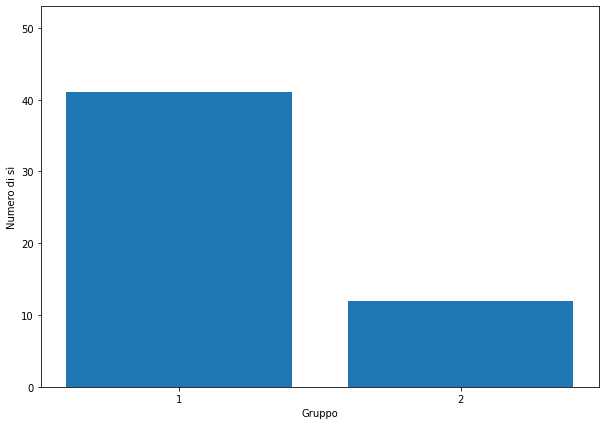

In [ ]:
# Dataset mediana
group1 = yes_df[yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].median()]
group2 = yes_df[yes_df['Confidence of yes'] < yes_df['Confidence of yes'].median()]

# Numero di sì nei due gruppi
g1 = list(group1[group1['Class'] == 'yes'].count())[2]
g2 = list(group2[group2['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2] # Numero di sì nei due gruppi
asse_x = ['1', '2'] # Nomi dei gruppi

plt.bar(asse_x, asse_y);
plt.xlabel('Gruppo');
plt.ylabel('Numero di sì');
plt.ylim(0, 53);

Quartili

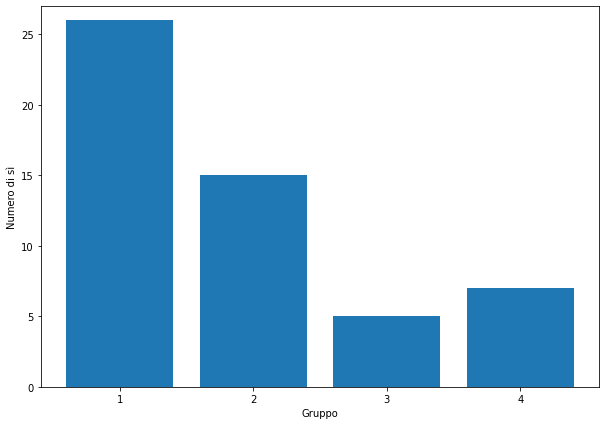

In [ ]:
# Dataset quartili
quart1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
quart2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
quart3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
quart4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

# Numero di sì nei quattro gruppi
g1 = list(quart1[quart1['Class'] == 'yes'].count())[2]
g2 = list(quart2[quart2['Class'] == 'yes'].count())[2]
g3 = list(quart3[quart3['Class'] == 'yes'].count())[2]
g4 = list(quart4[quart4['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2, g3, g4] # Numero di sì nei due gruppi
asse_x = ['1', '2', '3', '4'] # Nomi dei gruppi

plt.bar(asse_x, asse_y);
plt.xlabel('Gruppo');
plt.ylabel('Numero di sì');
plt.ylim(0, 27);

Ottili

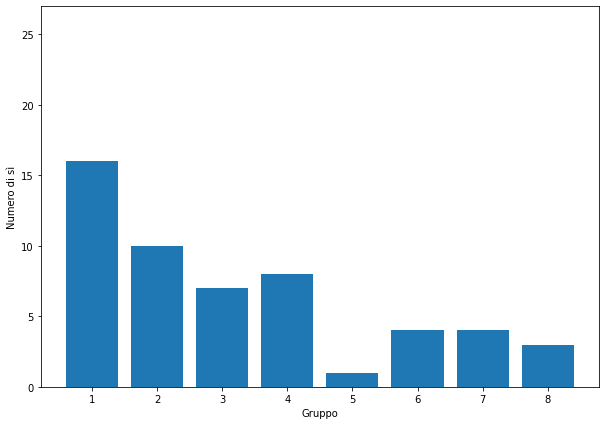

In [ ]:
# Dataset quartili
ott1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.875))]
ott2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.875)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
ott3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.625))]
ott4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.625)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
ott5 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.375))]
ott6 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.375)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
ott7 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.125))]
ott8 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.125)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

# Numero di sì nei quattro gruppi
g1 = list(ott1[ott1['Class'] == 'yes'].count())[2]
g2 = list(ott2[ott2['Class'] == 'yes'].count())[2]
g3 = list(ott3[ott3['Class'] == 'yes'].count())[2]
g4 = list(ott4[ott4['Class'] == 'yes'].count())[2]
g5 = list(ott5[ott5['Class'] == 'yes'].count())[2]
g6 = list(ott6[ott6['Class'] == 'yes'].count())[2]
g7 = list(ott7[ott7['Class'] == 'yes'].count())[2]
g8 = list(ott8[ott8['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2, g3, g4, g5, g6, g7, g8] # Numero di sì nei due gruppi
asse_x = ['1', '2', '3', '4', '5', '6', '7', '8'] # Nomi dei gruppi

plt.bar(asse_x, asse_y);
plt.xlabel('Gruppo');
plt.ylabel('Numero di sì');
plt.ylim(0, 27);